In [22]:
!pip3 install torch torchvision torchaudio
!pip3 install ale_py gymnasium
!pip3 install opencv-python
!pip3 install pympler

In [3]:
import os
from collections import defaultdict
from collections import deque
import random
import sys
from pympler import asizeof
import gc

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch
import numpy as np
import cv2

import ale_py
import gymnasium as gym

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from tqdm import tqdm

gym.register_envs(ale_py)

env = gym.make("ALE/Pong-v5")

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ===== CONFIGURABLE PARAMETERS =====
# Image cropping parameters - adjust these as needed
CROP_TOP = 34      # Pixels to crop from top
CROP_BOTTOM = 16    # Pixels to crop from bottom
CROP_LEFT = 0       # Pixels to crop from left
CROP_RIGHT = 0      # Pixels to crop from right
RESIZE_WIDTH = 84   # Final width after resizing
RESIZE_HEIGHT = 84  # Final height after resizing

# Training hyperparameters
LEARNING_RATE = 0.00025
N_EPISODES = 10000
START_EPSILON = 1.0
FINAL_EPSILON = 0.1
EPSILON_DECAY = (START_EPSILON - FINAL_EPSILON) / 1000000  # Decay over 1 million steps
DISCOUNT_FACTOR = 0.99
MEMORY_CAPACITY = 1000000  # Typical: 1 million transitions
MEMORY_FILL_SIZE = 50000   # Fill buffer before training starts
MINIBATCH_SIZE = 32        # Standard DQN uses 32
TARGET_UPDATE_FREQ = 10000 # Sync target net every 10k steps
MAX_STEPS_PER_EPISODE = 5000 # 10000 Long enough for Pong
TOTAL_STEPS = N_EPISODES * MAX_STEPS_PER_EPISODE
REWARD_CLIP = True          # Clip to [-1, 1]
MODEL_FILE = "dqn_pong"
LOAD_MODEL = "dqn_pong_best.pth"  # Set to False to train from scratch
# ===================================

Using device: cpu


In [29]:
# preprocess image demonstration
def preprocess(obs,
               crop_top=CROP_TOP,
               crop_bottom=CROP_BOTTOM,
               crop_left=CROP_LEFT,
               crop_right=CROP_RIGHT,
               resize_width=RESIZE_WIDTH,
               resize_height=RESIZE_HEIGHT):
    # Convert to grayscale
    if len(obs.shape) == 3 and obs.shape[2] == 3:
        greyscaled = np.dot(obs[..., :3], [0.299, 0.587, 0.114])
    else:
        greyscaled = obs

    # Get image dimensions
    height, width = greyscaled.shape

    # Calculate crop boundaries
    top_bound = crop_top
    bottom_bound = height - crop_bottom
    left_bound = crop_left
    right_bound = width - crop_right

    # Perform cropping
    cropped = greyscaled[top_bound:bottom_bound, left_bound:right_bound]

    # Resize
    resized = cv2.resize(cropped, (resize_width, resize_height),
                         interpolation=cv2.INTER_NEAREST)

    return resized

In [17]:
# defining neural network
# based on this architecture: https://arxiv.org/pdf/1312.5602
# code written by Claude Sonnet 4

class DQN(nn.Module):
    def __init__(self, num_actions, in_channels=4):
        super(DQN, self).__init__()

        # Convolutional layers (standard DQN architecture)
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        # Dynamically calculate linear layer size
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, RESIZE_HEIGHT, RESIZE_WIDTH)
            dummy = F.relu(self.conv1(dummy))
            dummy = F.relu(self.conv2(dummy))
            dummy = F.relu(self.conv3(dummy))
            self.linear_size = dummy.view(1, -1).size(1)

        self.fc1 = nn.Linear(self.linear_size, 512)
        self.fc2 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# example input: batch of 32 preprocessed frames
# batch_size = 32
# input_tensor = torch.randn(batch_size, 4, 25, 50) # Corrected input shape

# forward pass
# model = DQN(env.action_space.n)
# q_values = model(input_tensor)
# print(f"Input shape: {input_tensor.shape}")
# print(f"Output Q-values shape: {q_values.shape}")

In [18]:
class ReplayMemory:
    def __init__(self, capacity, state_shape):
        self.capacity = capacity
        self.state_shape = state_shape
        # Pre-allocate contiguous arrays
        self.states = np.zeros((capacity, *state_shape), dtype=np.uint8)
        self.next_states = np.zeros((capacity, *state_shape), dtype=np.uint8)
        self.actions = np.zeros(capacity, dtype=np.int32)
        self.rewards = np.zeros(capacity, dtype=np.float16)  # Reduce precision
        self.dones = np.zeros(capacity, dtype=np.bool_)
        self.position = 0
        self.size = 0

    def push(self, state, action, reward, next_state, done):
        self.states[self.position] = state
        self.next_states[self.position] = next_state
        self.actions[self.position] = action
        self.rewards[self.position] = reward
        self.dones[self.position] = done

        self.position = (self.position + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        indices = np.random.choice(self.size, batch_size, replace=False)
        return (
            self.states[indices],
            self.actions[indices],
            self.rewards[indices],
            self.next_states[indices],
            self.dones[indices]
        )

    def __len__(self):
        return self.size

    def memory_usage_gb(self):
        total_bytes = (self.states.nbytes + self.next_states.nbytes +
                       self.actions.nbytes + self.rewards.nbytes +
                       self.dones.nbytes)
        return total_bytes / (1024 ** 3)

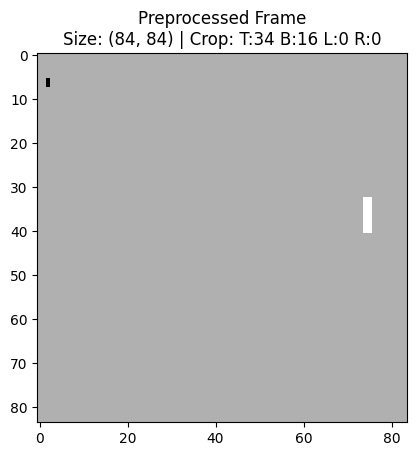

Pre-filling replay memory...


Pre-filling replay memory: 100%|████████| 10000/10000 [00:06<00:00, 1487.68it/s]


In [19]:
# Initialize replay memory
state_shape = (4, RESIZE_HEIGHT, RESIZE_WIDTH)
replay_memory = ReplayMemory(MEMORY_CAPACITY, state_shape)

# Reset environment and initialize frame stack
obs, info = env.reset()
frame = preprocess(obs)

# Visualize the first preprocessed frame
plt.imshow(frame, cmap='gray')
plt.title(f"Preprocessed Frame\nSize: {frame.shape} | Crop: T:{CROP_TOP} B:{CROP_BOTTOM} L:{CROP_LEFT} R:{CROP_RIGHT}")
plt.show()

frame_stack = deque(maxlen=4)
for _ in range(4):
    frame_stack.append(frame)
state = np.stack(frame_stack, axis=0)

# Pre-fill replay memory
print("Pre-filling replay memory...")
for _ in tqdm(range(MEMORY_FILL_SIZE), desc="Pre-filling replay memory"):
    action = env.action_space.sample()
    next_obs, reward, done, truncated, info = env.step(action)

    # Clip reward if enabled
    if REWARD_CLIP:
        reward = np.clip(reward, -1, 1)

    next_frame = preprocess(next_obs)
    frame_stack.append(next_frame)
    next_state = np.stack(frame_stack, axis=0)

    replay_memory.push(state, action, reward, next_state, done)
    state = next_state

    if done or truncated:
        obs, info = env.reset()
        frame = preprocess(obs)
        frame_stack.clear()
        for _ in range(4):
            frame_stack.append(frame)
        state = np.stack(frame_stack, axis=0)

In [20]:
# Initialize networks
online_net = DQN(env.action_space.n).to(device)
target_net = DQN(env.action_space.n).to(device)
target_net.load_state_dict(online_net.state_dict())
target_net.eval()

# === Load saved weights to continue training ===
if LOAD_MODEL:
    online_net.load_state_dict(torch.load(f"{LOAD_MODEL}", map_location=device))
    target_net.load_state_dict(online_net.state_dict())

# Optimizer
optimizer = optim.RMSprop(
    online_net.parameters(),
    lr=LEARNING_RATE,
    alpha=0.95,
    momentum=0.95,
    eps=0.01
)

In [21]:
# Agent class
class Agent:
    def __init__(self, env, initial_epsilon, epsilon_decay, final_epsilon, discount_factor):
        self.env = env
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.discount_factor = discount_factor

    def get_action(self, state, model):
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0) / 255.0
            with torch.no_grad():
                q_values = model(state_tensor)
            return q_values.argmax().item()

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [23]:
# Initialize agent
agent = Agent(
    env=env,
    initial_epsilon=START_EPSILON,
    epsilon_decay=EPSILON_DECAY,
    final_epsilon=FINAL_EPSILON,
    discount_factor=DISCOUNT_FACTOR,
)

# Training loop
total_steps = 0
episode_rewards = []
episode_losses = []
episode_steps = []
best_reward = -float('inf')

In [24]:
print("Starting training...")
for episode in tqdm(range(N_EPISODES), desc="Training episodes"):
    steps = 0
    obs, info = env.reset()
    frame = preprocess(obs)

    frame_stack = deque(maxlen=4)
    for _ in range(4):
        frame_stack.append(frame)
    state = np.stack(frame_stack, axis=0)

    done = False
    truncated = False
    episode_reward = 0
    step_losses = []

    while not (done or truncated) and steps < MAX_STEPS_PER_EPISODE:
        steps += 1
        action = agent.get_action(state, online_net)
        next_obs, reward, done, truncated, info = env.step(action)

        # Clip reward if enabled
        if REWARD_CLIP:
            reward = np.clip(reward, -1, 1)

        episode_reward += reward

        next_frame = preprocess(next_obs)
        frame_stack.append(next_frame)
        next_state = np.stack(frame_stack, axis=0)

        replay_memory.push(state, action, reward, next_state, done)
        state = next_state

        # Update model if we have enough samples
        if len(replay_memory) > MINIBATCH_SIZE and total_steps % 4 == 0:
            batch_data = replay_memory.sample(MINIBATCH_SIZE)
            states, actions, rewards, next_states, dones = batch_data

            # Convert to tensors (reuse variables)
            states_tensor = torch.tensor(states, dtype=torch.float32, device=device) / 255.0
            next_states_tensor = torch.tensor(next_states, dtype=torch.float32, device=device) / 255.0
            actions_tensor = torch.tensor(actions, dtype=torch.long, device=device)
            rewards_tensor = torch.tensor(rewards, dtype=torch.float32, device=device)
            dones_tensor = torch.tensor(dones, dtype=torch.float32, device=device)

            # Compute Q-values
            current_q = online_net(states_tensor).gather(1, actions_tensor.unsqueeze(1)).squeeze(1)

            # Compute target Q-values
            with torch.no_grad():
                next_q = target_net(next_states_tensor).max(1)[0]
                target_q = rewards_tensor + DISCOUNT_FACTOR * next_q * (1 - dones_tensor)

            # Compute loss
            loss = F.mse_loss(current_q, target_q)
            step_losses.append(loss.item())

            # Optimize
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            for param in online_net.parameters():
                if param.grad is not None:
                    param.grad.data.clamp_(-1, 1)

            optimizer.step()
            del states_tensor, next_states_tensor, actions_tensor, rewards_tensor, dones_tensor

        # Update target network
        total_steps += 1
        if total_steps % TARGET_UPDATE_FREQ == 0:
            target_net.load_state_dict(online_net.state_dict())
        if total_steps % 500 == 0:  # Clear cache periodically
            torch.cuda.empty_cache()
            gc.collect()

        # Decay epsilon
        agent.decay_epsilon()

    # Record metrics
    episode_rewards.append(episode_reward)
    if step_losses:
        avg_loss = sum(step_losses) / len(step_losses)
        episode_losses.append(avg_loss)
    else:
        episode_losses.append(0)
    episode_steps.append(steps)

    # Save best model
    if episode_reward > best_reward:
        best_reward = episode_reward
        torch.save(online_net.state_dict(), f"{MODEL_FILE}_best.pth")

    if episode % 10 == 0:
        avg_reward = np.mean(episode_rewards[-10:]) if len(episode_rewards) >= 10 else np.mean(episode_rewards)
        avg_steps = np.mean(episode_steps[-10:]) if len(episode_steps) >= 10 else np.mean(episode_steps)
        mem_usage = replay_memory.memory_usage_gb()

        print(f"Episode {episode}: Reward={episode_reward:.2f}, "
              f"Avg Reward (10)={avg_reward:.2f}, "
              f"Steps={steps}, Avg Steps (10)={avg_steps:.0f}, "
              f"Epsilon={agent.epsilon:.4f}, "
              f"Loss={episode_losses[-1]:.4f}, "
              f"ReplayMemory size={mem_usage:.6f} GB, "
              f"Online net={asizeof.asizeof(online_net)/ (1024 ** 3):.6f} GB, "
              f"Offline net={asizeof.asizeof(target_net)/ (1024 ** 3):.6f} GB")

# Save final model
torch.save(online_net.state_dict(), f"{MODEL_FILE}_final.pth")
print("Training complete. Models saved.")

Starting training...


Training episodes:   0%|                   | 1/10000 [00:35<99:17:06, 35.75s/it]

Episode 0: Reward=-19.00, Avg Reward (10)=-19.00, Steps=1042, Avg Steps (10)=1042, Epsilon=0.9999, Loss=0.0222, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   0%|                  | 11/10000 [06:08<95:01:31, 34.25s/it]

Episode 10: Reward=-21.00, Avg Reward (10)=-20.00, Steps=824, Avg Steps (10)=954, Epsilon=0.9990, Loss=0.0224, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   0%|                  | 21/10000 [11:32<91:36:19, 33.05s/it]

Episode 20: Reward=-19.00, Avg Reward (10)=-20.50, Steps=1000, Avg Steps (10)=931, Epsilon=0.9981, Loss=0.0216, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   0%|                  | 31/10000 [16:58<91:29:32, 33.04s/it]

Episode 30: Reward=-21.00, Avg Reward (10)=-20.10, Steps=887, Avg Steps (10)=938, Epsilon=0.9972, Loss=0.0213, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   0%|                  | 41/10000 [22:19<89:22:25, 32.31s/it]

Episode 40: Reward=-20.00, Avg Reward (10)=-20.40, Steps=926, Avg Steps (10)=922, Epsilon=0.9963, Loss=0.0097, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   1%|                  | 51/10000 [27:39<95:30:41, 34.56s/it]

Episode 50: Reward=-19.00, Avg Reward (10)=-20.40, Steps=1044, Avg Steps (10)=921, Epsilon=0.9954, Loss=0.0031, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   1%|                  | 61/10000 [33:20<91:36:23, 33.18s/it]

Episode 60: Reward=-21.00, Avg Reward (10)=-19.70, Steps=882, Avg Steps (10)=981, Epsilon=0.9945, Loss=0.0021, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   1%|▏                 | 71/10000 [38:47<90:48:21, 32.92s/it]

Episode 70: Reward=-20.00, Avg Reward (10)=-20.50, Steps=920, Avg Steps (10)=945, Epsilon=0.9936, Loss=0.0021, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   1%|▏                 | 81/10000 [44:27<95:16:48, 34.58s/it]

Episode 80: Reward=-20.00, Avg Reward (10)=-20.10, Steps=921, Avg Steps (10)=974, Epsilon=0.9927, Loss=0.0028, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   1%|▏                 | 91/10000 [49:50<94:48:16, 34.44s/it]

Episode 90: Reward=-21.00, Avg Reward (10)=-20.30, Steps=880, Avg Steps (10)=927, Epsilon=0.9918, Loss=0.0029, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   1%|▏                | 101/10000 [55:01<88:02:46, 32.02s/it]

Episode 100: Reward=-20.00, Avg Reward (10)=-20.70, Steps=842, Avg Steps (10)=888, Epsilon=0.9909, Loss=0.0030, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   1%|▏              | 111/10000 [1:00:14<84:33:33, 30.78s/it]

Episode 110: Reward=-21.00, Avg Reward (10)=-20.40, Steps=872, Avg Steps (10)=897, Epsilon=0.9900, Loss=0.0033, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   1%|▏              | 121/10000 [1:05:42<87:27:20, 31.87s/it]

Episode 120: Reward=-21.00, Avg Reward (10)=-20.30, Steps=826, Avg Steps (10)=937, Epsilon=0.9891, Loss=0.0033, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   1%|▏              | 131/10000 [1:11:02<87:57:35, 32.09s/it]

Episode 130: Reward=-21.00, Avg Reward (10)=-20.60, Steps=884, Avg Steps (10)=899, Epsilon=0.9882, Loss=0.0039, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   1%|▏              | 141/10000 [1:16:44<88:53:49, 32.46s/it]

Episode 140: Reward=-21.00, Avg Reward (10)=-20.00, Steps=783, Avg Steps (10)=965, Epsilon=0.9873, Loss=0.0037, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   2%|▏              | 151/10000 [1:22:03<91:58:57, 33.62s/it]

Episode 150: Reward=-19.00, Avg Reward (10)=-20.30, Steps=1031, Avg Steps (10)=910, Epsilon=0.9864, Loss=0.0065, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   2%|▏              | 161/10000 [1:27:21<86:49:58, 31.77s/it]

Episode 160: Reward=-20.00, Avg Reward (10)=-20.20, Steps=930, Avg Steps (10)=904, Epsilon=0.9855, Loss=0.0031, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   2%|▎              | 171/10000 [1:32:33<86:09:59, 31.56s/it]

Episode 170: Reward=-20.00, Avg Reward (10)=-20.70, Steps=950, Avg Steps (10)=888, Epsilon=0.9846, Loss=0.0035, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   2%|▎              | 181/10000 [1:38:00<92:11:18, 33.80s/it]

Episode 180: Reward=-21.00, Avg Reward (10)=-20.00, Steps=824, Avg Steps (10)=928, Epsilon=0.9837, Loss=0.0031, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   2%|▎              | 191/10000 [1:43:25<83:39:53, 30.71s/it]

Episode 190: Reward=-21.00, Avg Reward (10)=-20.40, Steps=764, Avg Steps (10)=930, Epsilon=0.9828, Loss=0.0036, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   2%|▎              | 201/10000 [1:48:46<88:28:18, 32.50s/it]

Episode 200: Reward=-20.00, Avg Reward (10)=-20.40, Steps=923, Avg Steps (10)=916, Epsilon=0.9819, Loss=0.0033, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   2%|▎              | 211/10000 [1:54:20<96:27:03, 35.47s/it]

Episode 210: Reward=-19.00, Avg Reward (10)=-20.50, Steps=1203, Avg Steps (10)=946, Epsilon=0.9810, Loss=0.0037, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   2%|▎              | 221/10000 [1:59:39<88:00:02, 32.40s/it]

Episode 220: Reward=-21.00, Avg Reward (10)=-20.20, Steps=914, Avg Steps (10)=909, Epsilon=0.9801, Loss=0.0034, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   2%|▎              | 231/10000 [2:05:18<95:27:52, 35.18s/it]

Episode 230: Reward=-19.00, Avg Reward (10)=-20.50, Steps=1130, Avg Steps (10)=965, Epsilon=0.9792, Loss=0.0035, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   2%|▎              | 241/10000 [2:10:47<84:35:11, 31.20s/it]

Episode 240: Reward=-21.00, Avg Reward (10)=-20.10, Steps=792, Avg Steps (10)=935, Epsilon=0.9783, Loss=0.0047, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   3%|▍              | 251/10000 [2:16:43<92:53:55, 34.30s/it]

Episode 250: Reward=-20.00, Avg Reward (10)=-20.50, Steps=842, Avg Steps (10)=933, Epsilon=0.9774, Loss=0.0075, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   3%|▎             | 261/10000 [2:23:16<102:53:56, 38.04s/it]

Episode 260: Reward=-21.00, Avg Reward (10)=-20.10, Steps=824, Avg Steps (10)=995, Epsilon=0.9765, Loss=0.0068, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   3%|▍              | 271/10000 [2:29:05<93:38:45, 34.65s/it]

Episode 270: Reward=-19.00, Avg Reward (10)=-19.90, Steps=938, Avg Steps (10)=969, Epsilon=0.9756, Loss=0.0060, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   3%|▍              | 281/10000 [2:34:31<94:05:10, 34.85s/it]

Episode 280: Reward=-20.00, Avg Reward (10)=-20.60, Steps=1158, Avg Steps (10)=926, Epsilon=0.9747, Loss=0.0056, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   3%|▍              | 291/10000 [2:40:25<93:26:16, 34.65s/it]

Episode 290: Reward=-20.00, Avg Reward (10)=-20.10, Steps=992, Avg Steps (10)=1004, Epsilon=0.9738, Loss=0.0053, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   3%|▍              | 301/10000 [2:46:06<95:41:44, 35.52s/it]

Episode 300: Reward=-20.00, Avg Reward (10)=-20.10, Steps=916, Avg Steps (10)=968, Epsilon=0.9729, Loss=0.0042, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   3%|▍              | 311/10000 [2:51:35<87:28:21, 32.50s/it]

Episode 310: Reward=-21.00, Avg Reward (10)=-20.50, Steps=980, Avg Steps (10)=922, Epsilon=0.9720, Loss=0.0042, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   3%|▍              | 321/10000 [2:57:22<92:25:59, 34.38s/it]

Episode 320: Reward=-21.00, Avg Reward (10)=-20.10, Steps=852, Avg Steps (10)=984, Epsilon=0.9711, Loss=0.0041, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   3%|▍              | 331/10000 [3:02:50<87:51:59, 32.71s/it]

Episode 330: Reward=-21.00, Avg Reward (10)=-20.50, Steps=928, Avg Steps (10)=931, Epsilon=0.9702, Loss=0.0038, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   3%|▌              | 341/10000 [3:09:06<98:16:39, 36.63s/it]

Episode 340: Reward=-20.00, Avg Reward (10)=-19.90, Steps=951, Avg Steps (10)=1068, Epsilon=0.9693, Loss=0.0048, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   4%|▌              | 351/10000 [3:14:25<88:20:30, 32.96s/it]

Episode 350: Reward=-21.00, Avg Reward (10)=-20.40, Steps=888, Avg Steps (10)=909, Epsilon=0.9684, Loss=0.0041, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   4%|▌              | 361/10000 [3:20:02<90:52:01, 33.94s/it]

Episode 360: Reward=-20.00, Avg Reward (10)=-20.00, Steps=938, Avg Steps (10)=969, Epsilon=0.9675, Loss=0.0034, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   4%|▌              | 371/10000 [3:25:35<86:02:05, 32.17s/it]

Episode 370: Reward=-21.00, Avg Reward (10)=-20.20, Steps=848, Avg Steps (10)=948, Epsilon=0.9666, Loss=0.0031, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   4%|▌              | 381/10000 [3:31:22<91:29:35, 34.24s/it]

Episode 380: Reward=-19.00, Avg Reward (10)=-19.70, Steps=999, Avg Steps (10)=1005, Epsilon=0.9657, Loss=0.0038, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   4%|▌              | 391/10000 [3:37:09<95:33:50, 35.80s/it]

Episode 390: Reward=-18.00, Avg Reward (10)=-19.80, Steps=1073, Avg Steps (10)=990, Epsilon=0.9648, Loss=0.0039, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   4%|▌              | 401/10000 [3:42:49<93:19:19, 35.00s/it]

Episode 400: Reward=-18.00, Avg Reward (10)=-19.90, Steps=1149, Avg Steps (10)=971, Epsilon=0.9639, Loss=0.0039, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   4%|▌              | 411/10000 [3:48:19<87:47:45, 32.96s/it]

Episode 410: Reward=-20.00, Avg Reward (10)=-20.00, Steps=1086, Avg Steps (10)=948, Epsilon=0.9630, Loss=0.0037, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   4%|▋              | 421/10000 [3:54:15<95:12:17, 35.78s/it]

Episode 420: Reward=-18.00, Avg Reward (10)=-19.70, Steps=1103, Avg Steps (10)=1011, Epsilon=0.9621, Loss=0.0038, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   4%|▋              | 431/10000 [3:59:52<92:52:41, 34.94s/it]

Episode 430: Reward=-20.00, Avg Reward (10)=-20.50, Steps=898, Avg Steps (10)=968, Epsilon=0.9612, Loss=0.0037, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   4%|▋              | 441/10000 [4:05:20<86:13:42, 32.47s/it]

Episode 440: Reward=-21.00, Avg Reward (10)=-20.50, Steps=824, Avg Steps (10)=946, Epsilon=0.9603, Loss=0.0043, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   5%|▋              | 451/10000 [4:10:46<85:31:40, 32.24s/it]

Episode 450: Reward=-20.00, Avg Reward (10)=-20.30, Steps=958, Avg Steps (10)=930, Epsilon=0.9594, Loss=0.0036, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   5%|▋              | 461/10000 [4:16:36<92:23:52, 34.87s/it]

Episode 460: Reward=-20.00, Avg Reward (10)=-20.00, Steps=1012, Avg Steps (10)=1003, Epsilon=0.9585, Loss=0.0048, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   5%|▋              | 471/10000 [4:22:08<91:01:51, 34.39s/it]

Episode 470: Reward=-20.00, Avg Reward (10)=-20.20, Steps=1176, Avg Steps (10)=950, Epsilon=0.9576, Loss=0.0055, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   5%|▋              | 481/10000 [4:27:58<90:22:31, 34.18s/it]

Episode 480: Reward=-20.00, Avg Reward (10)=-19.70, Steps=842, Avg Steps (10)=1002, Epsilon=0.9567, Loss=0.0058, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   5%|▋              | 491/10000 [4:33:20<84:44:53, 32.08s/it]

Episode 490: Reward=-21.00, Avg Reward (10)=-20.30, Steps=932, Avg Steps (10)=921, Epsilon=0.9558, Loss=0.0061, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   5%|▊              | 501/10000 [4:39:03<85:53:19, 32.55s/it]

Episode 500: Reward=-20.00, Avg Reward (10)=-20.20, Steps=898, Avg Steps (10)=982, Epsilon=0.9549, Loss=0.0059, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   5%|▊              | 511/10000 [4:44:39<89:12:20, 33.84s/it]

Episode 510: Reward=-20.00, Avg Reward (10)=-20.10, Steps=996, Avg Steps (10)=959, Epsilon=0.9540, Loss=0.0054, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   5%|▊              | 521/10000 [4:50:09<84:11:03, 31.97s/it]

Episode 520: Reward=-20.00, Avg Reward (10)=-20.20, Steps=838, Avg Steps (10)=943, Epsilon=0.9531, Loss=0.0053, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   5%|▊              | 531/10000 [4:55:40<83:43:17, 31.83s/it]

Episode 530: Reward=-20.00, Avg Reward (10)=-20.40, Steps=844, Avg Steps (10)=920, Epsilon=0.9522, Loss=0.0055, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   5%|▊              | 541/10000 [5:01:05<85:23:05, 32.50s/it]

Episode 540: Reward=-21.00, Avg Reward (10)=-20.10, Steps=792, Avg Steps (10)=926, Epsilon=0.9513, Loss=0.0057, ReplayMemory size=1.314445 GB, Online net=0.000020 GB, Offline net=0.000020 GB


Training episodes:   5%|▊              | 544/10000 [5:03:26<87:54:23, 33.47s/it]


KeyboardInterrupt: 

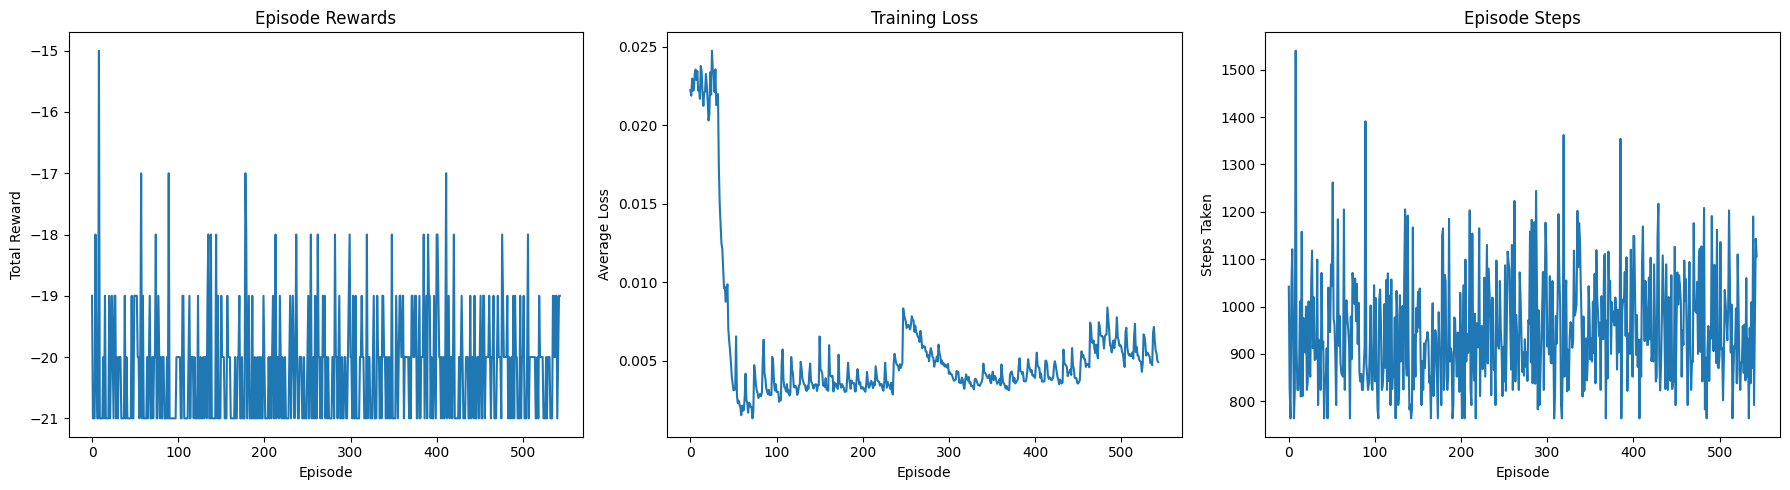

In [25]:
# Plot results
plt.figure(figsize=(18, 5))

# Plot rewards
plt.subplot(1, 3, 1)
plt.plot(episode_rewards)
plt.title("Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")

# Plot loss
plt.subplot(1, 3, 2)
plt.plot(episode_losses)
plt.title("Training Loss")
plt.xlabel("Episode")
plt.ylabel("Average Loss")

# Plot steps
plt.subplot(1, 3, 3)
plt.plot(episode_steps)
plt.title("Episode Steps")
plt.xlabel("Episode")
plt.ylabel("Steps Taken")

plt.tight_layout()
plt.savefig("training_results.png")
plt.show()


Replay memory is empty.


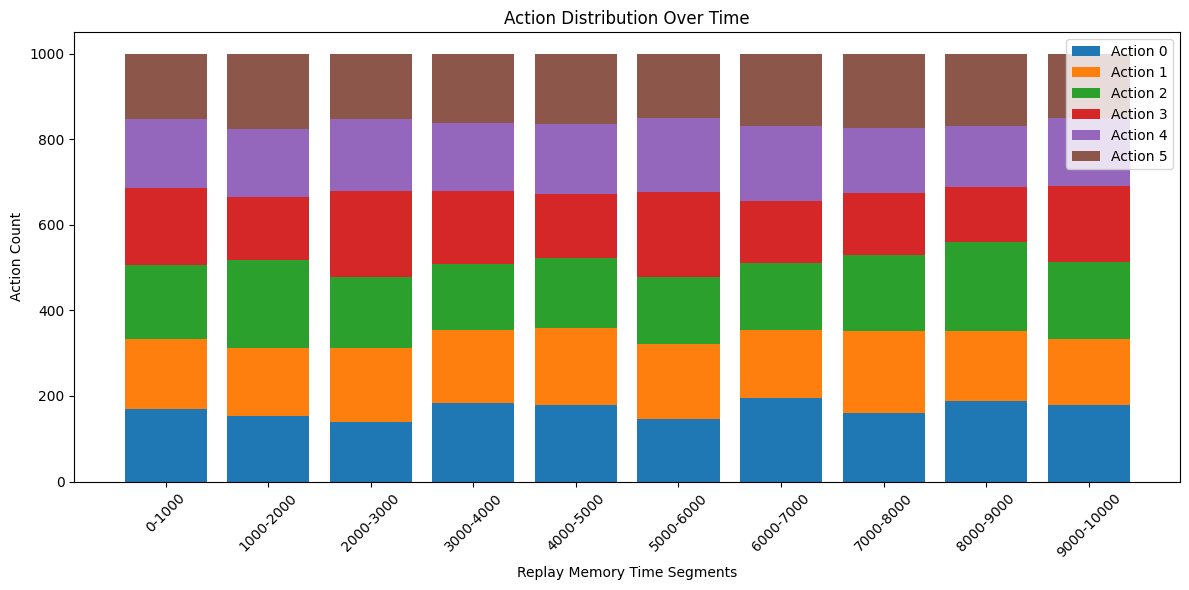

In [37]:
action_names = None
bins = 10

if replay_memory.size != 0:
    print("Replay memory is empty.")

    actions = replay_memory.actions[:replay_memory.size]
    total = len(actions)
    bin_size = total // bins
    
    action_set = np.unique(actions)
    num_actions = np.max(actions) + 1  # assumes 0-based continuous actions
    distribution = np.zeros((bins, num_actions), dtype=int)
    
    for i in range(bins):
        start = i * bin_size
        end = (i + 1) * bin_size if i < bins - 1 else total
        bin_actions = actions[start:end]
        counts = np.bincount(bin_actions, minlength=num_actions)
        distribution[i] = counts
    
    # Prepare labels
    if action_names is None:
        action_names = [f"Action {i}" for i in range(num_actions)]
    time_labels = [f"{i * bin_size}-{(i + 1) * bin_size}" for i in range(bins)]
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    for i in range(num_actions):
        ax.bar(np.arange(bins), distribution[:, i], label=action_names[i], bottom=np.sum(distribution[:, :i], axis=1))
    
    ax.set_xticks(np.arange(bins))
    ax.set_xticklabels(time_labels, rotation=45)
    ax.set_xlabel("Replay Memory Time Segments")
    ax.set_ylabel("Action Count")
    ax.set_title("Action Distribution Over Time")
    ax.legend()
    plt.tight_layout()
    plt.show()
